# Parallel stochastic simulation

Stochastic simulation is an [embarrassingly parallel problem](https://en.wikipedia.org/wiki/Embarrassingly_parallel) in which realizations are only a function of the random seed, and can be generated indenpendently one from another. Although this is a well-known fact, there has not been reasonable effort in geostatistical software to exploit modern hardware such as HPC clusters and the cloud (e.g. AWS, MS Azure).

In GeoStats.jl, *all* stochastic simulation algorithms generate realizations in parallel by default. The package exploits Julia's built-in support for parallel execution, and works seamlessly on personal laptops with multiple cores as well as on high-performance computer clusters with multiple nodes.

In this tutorial, we demonstrate how to generate realizations with direct Gaussian simulation in parallel. The same script can be run on a computer cluster where thousands of processes are available.

Before we proceed, please install the following packages:

In [1]:
] add GeoStats DirectGaussianSimulation Plots PyPlot

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
using Random; Random.seed!(2000); # make sure this tutorial is reproducible

## Number of processes

When you start Julia, it starts with a single process:

In [3]:
using Distributed

nprocs()

1

In order to run simulations in parallel with GeoStats.jl, the first thing we need to do is increase the number of processes in the pool *before* loading the package. The command `addprocs` adds a given number of processes for parallel execution:

In [4]:
addprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

Notice that `addprocs()` when called without an argument, adds the number of *logical* cores available in the machine.

> **WARNING:** If you are on Windows 8 or an older version of the operating system, you will likely experience a slow down. Please add the number of *physical* cores instead that can be found externally in computer settings or via packages such as [CpuId.jl](https://github.com/m-j-w/CpuId.jl) and [Hwloc.jl](https://github.com/JuliaParallel/Hwloc.jl).

On a HPC cluster, computing resources are generally requested via a resource manager (e.g. SLURM, PBS). In this case, the package [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl) provides variants of the built-in `addprocs()` for adding processes to the pool effortlessly. For example, we can use `addprocs_slurm(1000)` to request 1000 processes in a SLURM job.

Now that the processes are available, we can run normal GeoStats.jl scripts and they will automatically distribute the execution among the processes.

## Problem definition

In [5]:
using GeoStats

geodata = readgeotable("data/precipitation.csv", coordnames=[:x,:y])
domain  = RegularGrid((0.,0.), (100.,100.), dims=(20,20))
problem = SimulationProblem(geodata, domain, :precipitation, 30)

2D SimulationProblem (conditional)
  data:      3×4 GeoDataFrame (x and y)
  domain:    20×20 RegularGrid{Float64,2}
  variables: precipitation (Float64)
  N° reals:  30

## Solving the problem

In [6]:
using DirectGaussianSimulation

solver = DirectGaussSim(
    :precipitation => (variogram=SphericalVariogram(range=20.),)
)

DirectGaussSim
  └─precipitation
    └─variogram = SphericalVariogram{Float64,Euclidean}
  range: Float64 20.0
  sill: Float64 1.0
  nugget: Float64 0.0
  distance: Euclidean



In [7]:
solution = solve(problem, solver)

2D SimulationSolution
  domain: 20×20 RegularGrid{Float64,2}
  variables: precipitation

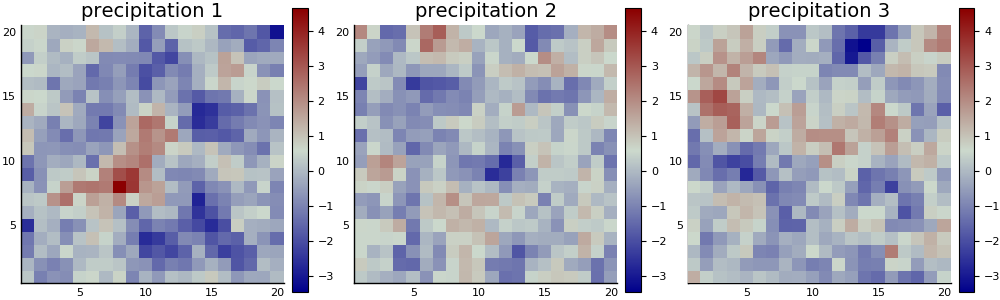

In [8]:
using Plots; pyplot()

plot(solution, size=(1000,300))

## Remarks

- In GeoStats.jl, *parallel* stochastic simulation is achieved with ease. From a user's perspective, it consists of a single call to `addprocs` variants.
- Users can utilize hardware resources such as HPC clusters and the cloud to speed up simulation jobs. In theory, the speedup is upper bounded by the number of computing nodes/cores/processes available. In practice, this translates into generating multiple realizations within the time required for one.
- On a personal laptop or desktop, serial (non-parallel) simulation can often outperform parallel simulation. See the example above.